# Tutorial: Toy Photometry Model on a Grid

This will be your first fully (well, mostly) worked-out inference problem for the course. We're going to keep it unrealistically simple in order to focus on process; you'll solve the same problem using different methods later on. Later tutorials will be based on real-life (if still somewhat simplified) astrophysics inferences.

Specifically, you will
* define a generative model for the scenario described
* generate fake data to fit, since this is a made-up problem
* apply Bayes' Law, evaluating the posterior over a grid in parameter space
* qualitatively evaluate the goodness of fit
* compute credible intervals and regions
* see why evaluation on a grid is not ideal for higher-dimensional models

In [314]:
TutorialName = 'toy_grid'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
from scipy.optimize import minimize
import incredible as cr

## Problem definition

The problem we will address here is that of measuring the position and flux of a point-like source in sparse imaging data. By "sparse", we mean that we have relatively few detected photons in each pixel of our image, such that the sampling distribution is Poisson rather than approximately Gaussian. This is generally the case for observations at X-ray wavelengths and shorter.

"Point-like" in this context means that the angular size of the source is smaller than point-spread-function (PSF) of our telescope, which describes the Green's function response of the optical system. That is, a truly point-like source would appear in our image as a smeared out shape (the PSF), and our source is small enough that it also looks like the PSF, with its true extent being negligible by comparison. Normally the PSF is larger than the pixel size of an image, so we actually do see the shape of the PSF; this is preferable to undersampling the image, in which case a point-like source would show up only in 1 pixel, but we would have no idea where in that pixel it was located.

The most egregious simplifying assumption we will make is that we recieve photons only from the source in question, without there being any backgrounds or other sources to confuse things. If we have a very small PSF and a very bright source, this might actually not be a terrible assumption, though generally we do have to worry about such things. We will also assume that we know the shape of the PSF, an uncorrelated (i.e. symmetric) 2D Gaussian. That is, the image we see is related to the true, unsmeared image by convolution with the kernel

$\mathrm{PSF}(x,y) = \frac{1}{2\pi\sigma^2} e^{-\frac{1}{2}\left(\frac{x^2+y^2}{\sigma^2}\right)}$.

However, we will not assume that we know the PSF width, $\sigma$, perfectly.

We'll see some features of real imaging data later in the course, but for now let's simply describe the source flux in terms of it's Poisson expectation value for the observation in question, rather than a real flux in units of energy per unit time and area.

To recap, our model is:
* There is a point-like source in the image at position $x_0$ and $y_0$, whose flux corresponds to a mean number of received photons of $\mu_0$ for whatever observation time we had. The true image on the sky could be approximately (i.e. for a true point source) written as $S(x,y) = \mu_0 \delta(x-x_0) \delta(y-y_0)$.
* The PSF of width $\sigma$ spreads out these photons, such that the expectation value for the photons in the measured image becomes $\mu(x,y) = \mathrm{PSF} \otimes S \approx \mu_0 \mathrm{PSF}(x-x_0 ,y-y_0)$. At written here, we'll approximate the convolution by just evaluating the PSF at the center of each pixel, rather than integrating over the finite solid angle of the pixel. This means we will need to manually normalize the discretized image $\mu(x,y)$ so that it integrates to $\mu_0$, but as a simplifying approximation it should be fine for our purposes.
* Finally, the measured number of photons in each pixel, $N(x,y)$, is generated from a Poisson sampling distribution, with mean given by $\mu(x,y)$.

What about priors? As always, you are encouraged to experiment to see what different choices might produce. As a baseline, though, let's adopt
* uniform priors, constrained to be within the image, on $x_0$ and $y_0$, on the basis that we probably knew the source would be in the image, but otherwise want to be translation invariant; and
* $p(\mu_0) \propto \mu_0^{-1/2}$, which happens to be the Jeffreys prior for a Poisson mean parameter, because we're feeling fancy;
* $p(\sigma) \propto \sigma^{-1}$, because the fanciness box has been opened, so we might as well also use the Jeffreys prior for a Gaussian scale parameter. This also has the nice property that it won't let $\sigma$ get too large, since we presumably have some bound on how large it might be. You can think of a prior like this as demanding that the data justify a spread (in the PSF, in this case), rather than assuming it might be arbitrarily large.

(Incidentally, the Jeffreys priors for $x$ and $y$ would be uniform on the real line, so we're pretty much at maximum fanciness for this problem.)

Before continuing with an implementation, go through our usual generative model sanity check: enumerate the model parameters and data, write down the probabilistic relationships among them, and visualize them with a PGM. Keep in mind which parameters will be free vs fixed in our initial analysis, as described above.

photon numbers in each pixel.
modeled by 2d Gaussian distribution centered around some points.
Flux(# of photons) N(x,y) is Poisson and the mean is mu.
Prior is uniform.

## Generate data

Since this is a fictional inference problem, we'll need to generate some fake data for you to fit. Fortunately, your expertise with generative models will make this straightforward!

For consistency, use the true model parameter values below in the notebook you turn in:

In [315]:
truth = {'x0':17.1, 'y0':12.75, 'mu0':50.0, 'sigma':3.0}

We'll be simpleminded, and have the $x$ and $y$ coordinates correspond to the 2nd and 1st indices into the image. That is, a $32 \times 32$ image spans pixel-center coordinates $x_i=0,1,\ldots,31$, and similarly for $y$. Please note that "2nd and 1st" is not a typo above; the convention for 2D images is usually that the first index is row (vertical) and the second is column (horizontal). To keep our brains from exploding, please implement this switch so that the horizontal axis of plots corresponds to $x$ and the vertical to $y$.

In [316]:
dim_x = 32
dim_y = 32

Produce a mock image of the dimension given above, and we'll visualize it below. There are two approaches one might take here. One is to compute $\mu(x,y)$ over the image (remembering the subtlety regarding the normalization of the PSF noted above) and then draw a Poisson sample for each pixel. The other, equivalently, is to do a single Poisson draw for the total number of photons we'll see, and assign their positions in the image according to the source position and PSF.

Note that you should technically handle the case of photons that land outside of the defined image, since the PSF tails go to infinity. This is relatively unlikely to be an issue for the values above, however.

In [317]:
import numpy as np
mock_image = np.zeros((dim_y, dim_x))
n=100
data=np.random.multivariate_normal([truth['y0'],truth['x0']]
                                ,[[truth['sigma']**2,0],[0,truth['sigma']**2]]
                                , size=n)
for y,x in data:
    y0,x0=int(y),int(x)
    mock_image[y0][x0]=st.poisson.rvs(truth['mu0'])/n

Have a look. The image should have a good amount of shot (Poisson) noise, but the center and width of the photon distribution should make sense in light of the `truth` values.

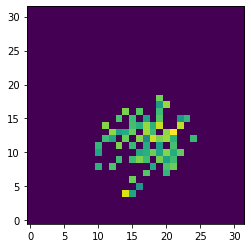

In [318]:
plt.imshow(mock_image, origin='lower');

Well done! However, it will be more useful to have everyone working with the same mock data, so that you can compare results with others and with our solutions. So, overwrite your hard work with this data set that was also generated from the model above:

In [319]:
mock_image = np.loadtxt('toy_photometry.dat')

**Checkpoint:** It should look - broadly - similar to yours.

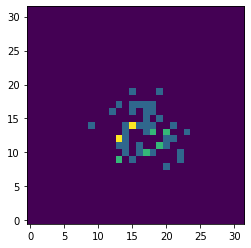

In [320]:
plt.imshow(mock_image, origin='lower');

For convenience, it's nice to also carry around arrays that store the $x$ and $y$ value corresponding to each pixel. This is massively redundant and wasteful from a memory perspective, but it makes it simple to use array arithmetic to, for e.g., compute the distance of every pixel from $(x_0,y_0)$. The code below defines a lightweight class to hold these arrays, along with the actual image.

In [321]:
class Image:
    def __init__(self, image):
        self.im = image
        self.imx,self.imy = np.meshgrid(range(image.shape[1]), range(image.shape[0]))

data = Image(mock_image)

To be explicit, `data.im` now points to `mock_image`, and `data.imx` and `data.imy` contain the coordinate information described above:

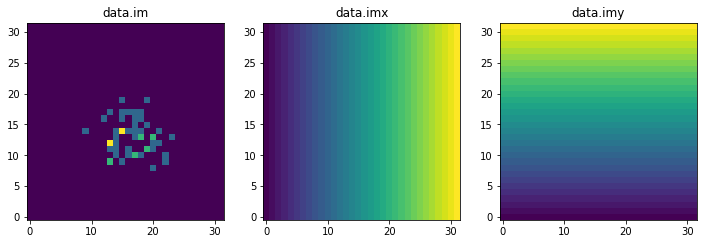

In [322]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig, ax = plt.subplots(1,3)
ax[0].imshow(data.im, origin='lower');
ax[0].set_title('data.im');
ax[1].imshow(data.imx, origin='lower');
ax[1].set_title('data.imx');
ax[2].imshow(data.imy, origin='lower');
ax[2].set_title('data.imy');

In [323]:
data.imx.shape

(32, 32)

## Implementation

It's time to write functions to evaluate the prior, sampling and posterior distributions.

Normally, we try to evaluate the _log_ of these distributions. This is because floating-point underflows can be an issue, especially when the sampling distribution is a product with many terms. Another benefit is that we don't have to worry about normalizing coefficients that don't depend on model parameters, unless we wanted to compute the absolute value of the evidence for some reason. Since we'll be evaluating over a grid in this notebook, we could always normalize the posterior later by dividing it by its numerical integral. If any of these functions should return zero probability, you can and should have them return a log-probability of $-\infty$.

Complete the function evaluating the log-prior. Remember that we want is to return a probability of 0 when any arguments are out of bounds or would cause numerical errors (e.g. $\sigma \leq 0$) rather than throwing an exception.

In [324]:
import scipy.stats as st
def log_prior(x0, y0, mu0, sigma):
    if 0<x0<32 and 0<y0<32 and 0<mu0<100 and 0<sigma<10.0:
        return 0
    return -np.inf

As always, we should make sure it returns some kind of value instead of crashing when fed an example parameter dictionary. We can just use `truth` for this type of check.

In [325]:
log_prior(**truth)

0

Next, implement the log-likelihood/sampling distribution. This is, of course, where all the fun of evaluating the model happens, although I'd suggest outsourcing the evaluation of $\mu(x,y)$ to a separate function; that way we can also easily check that it produces something reasonable. Keep in mind that our model before the PSF smooths things is just a delta function, so it isn't necessary to carry out the convolution in the model numerically. Hint: remember to normalize `mean_img` so that it contains the appropriate total expected counts.

In [349]:
xs,ys=np.meshgrid(range(32),range(32))
xs=xs.flatten()
ys=ys.flatten()
coords=[]
for x,y in zip(xs,ys):
    coords.append([x,y])
coords

[[0, 0],
 [1, 0],
 [2, 0],
 [3, 0],
 [4, 0],
 [5, 0],
 [6, 0],
 [7, 0],
 [8, 0],
 [9, 0],
 [10, 0],
 [11, 0],
 [12, 0],
 [13, 0],
 [14, 0],
 [15, 0],
 [16, 0],
 [17, 0],
 [18, 0],
 [19, 0],
 [20, 0],
 [21, 0],
 [22, 0],
 [23, 0],
 [24, 0],
 [25, 0],
 [26, 0],
 [27, 0],
 [28, 0],
 [29, 0],
 [30, 0],
 [31, 0],
 [0, 1],
 [1, 1],
 [2, 1],
 [3, 1],
 [4, 1],
 [5, 1],
 [6, 1],
 [7, 1],
 [8, 1],
 [9, 1],
 [10, 1],
 [11, 1],
 [12, 1],
 [13, 1],
 [14, 1],
 [15, 1],
 [16, 1],
 [17, 1],
 [18, 1],
 [19, 1],
 [20, 1],
 [21, 1],
 [22, 1],
 [23, 1],
 [24, 1],
 [25, 1],
 [26, 1],
 [27, 1],
 [28, 1],
 [29, 1],
 [30, 1],
 [31, 1],
 [0, 2],
 [1, 2],
 [2, 2],
 [3, 2],
 [4, 2],
 [5, 2],
 [6, 2],
 [7, 2],
 [8, 2],
 [9, 2],
 [10, 2],
 [11, 2],
 [12, 2],
 [13, 2],
 [14, 2],
 [15, 2],
 [16, 2],
 [17, 2],
 [18, 2],
 [19, 2],
 [20, 2],
 [21, 2],
 [22, 2],
 [23, 2],
 [24, 2],
 [25, 2],
 [26, 2],
 [27, 2],
 [28, 2],
 [29, 2],
 [30, 2],
 [31, 2],
 [0, 3],
 [1, 3],
 [2, 3],
 [3, 3],
 [4, 3],
 [5, 3],
 [6, 3],
 [7, 3]

In [353]:
truth

{'x0': 17.1, 'y0': 12.75, 'mu0': 50.0, 'sigma': 3.0}

In [394]:
def mean_img(x0, y0, mu0, sigma):
    image = np.zeros((dim_y, dim_x))
    n=100
    dat=np.random.multivariate_normal([y0,x0]
                                ,[[sigma,0],[0,sigma]]
                                , size=n)
    for y,x in dat:
        y1,x1=int(y),int(x)
        image[y1][x1]+=st.poisson.rvs(mu0)/n
    return image
mu = mean_img(**params)
def log_likelihood(data, **params):
    ll=0
    x0,y0,sigma=params['x0'],params['y0'],params['sigma']
    normlogpdf=np.sum(st.multivariate_normal.logpdf(coords,[y0,x0]
                                ,[[sigma,0],[0,sigma]]))
    pois=st.poisson.logpmf(sum(sum(data.im)),params['mu0'])
    return normlogpdf+pois

In [357]:
# check that it works
log_likelihood(data, **truth)

-33836.140739620125

For good measure, let's see what $\mu(x,y)$ looks like:

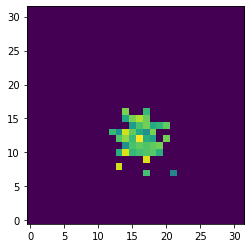

In [358]:
plt.imshow(mean_img(**truth), origin='lower');

and look at its integral, which should **not** (exercise for the reader) be precisely $\mu_0$:

In [359]:
mean_img(**truth).sum()

20.47

Finally, the log-posterior. As will often be the case, we will just return the sum of the log-prior and log-likelihood, i.e. we will neglect the normalizing constant (evidence), which is constant with repect to the model parameters.

The construction below is a good one to be in the habit of using. Usually, the likelihood is much more expensive to compute than the prior, and might even crash if passed prior-incompatible parameter values. So it's worth the extra check of a non-zero prior probability before attempting to evaluate the likelihood.

In [360]:
def log_posterior(data, **params):
    lnp = log_prior(**params)
    if np.isfinite(lnp):
        lnp += log_likelihood(data, **params)
    return lnp

In [361]:
## check that it works
log_posterior(data, **truth)

-33836.140739620125

If everything appears to work so far, we should be good to move on.

## Evaluating the posterior

We should now be able to define a grid and evaluate the posterior over it, as we've seen before. In practical terms, the extent of the grid defines the extent of our priors, regardless of whether they are uniform or not. As such, we need to ensure that the grid encompasses very close to 100% of the posterior, which means we might need to iteratively repeat this evalutaion.

A resonable approach is to use a numerical optimizer to find the maximum of the log-posterior (or the minimum of its additive inverse). That won't instantly tell us how wide to make the grid in order to contain nearly all the posterior probability, but it tells us a good place to center the grid to begin with.

We'll use `scipy.optimize.minimize` (imported above as `minimize`). Refer to its documentation if needed. Define the function that `minimize` will work on here.

Note that it will want a vector argument rather than a dictionary of parameter values. It's convenient therefore to define a standard ordering for the parameters that we can use any time that's relevant.

In [362]:
paramnames = ['x0', 'y0', 'mu0', 'sigma'] # the canonical parameter order, because I said so

In [363]:
data.im.sum()

52.0

In [364]:
def mlnpost(p, data):
    dic={'x0':p[0],'y0':p[1],'mu0':p[2],'sigma':p[3]}
    return -log_posterior(data,**dic)
    """
    p: a numpy array of parameter values in the order x0, y0, mu0, sigma
    Return value: minus the log-posterior
    """

Since we're pretending to not know the true parameters, let's start the optimization from an arbitrary guess: $(x_0,y_0)$ at the middle of the image, $\mu_0$ at the sum of the image, and $\sigma$ at a number I made up.

In [365]:
params = {'x0':17.1, 'y0':13.0, 'mu0':data.im.sum(), 'sigma':3.1}

The `scipy.optimize.minimize` function that we will use has a ton of options, and is probably worth reading the docs on as a matter of general preparation for life. For our purposes, the defaults are probably fine. However, it's a good idea to let the minimizer know that we aren't allowing all real values of all of the parameters, using the `bounds` option. This is because most of the methods in `minimize` will numerically approximate the derivatives of `mlnpost`; depending on our starting point and the typical order of magnitude of the parameters, it's entirely possible for many of the evaluations involved to be outside the allowed region, resulting in infinities returned from the prior, and terrible crashes. The `bounds` option should be a list of (`lower_limit`,`upper_limit`) tuples, where either can be `None`. Fill in the missing pieces of the list below, in agreement with the priors defined for this problem (we'll provide the last entry, for $\sigma$).

In [366]:
bounds = [(0,32), (0,32), (0,70), (0.0001,10)] 

Now we'll do the optimization and print out the best fit:

In [367]:
bestfit = minimize(mlnpost, [params[k] for k in paramnames], args=(data), bounds=bounds)
bestfit

/usr/lib/python3/dist-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


      fun: 32658.50900884884
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  528.51642242,  -825.80656897,     0.        , -9222.92534745])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 15
      nit: 1
     njev: 3
   status: 0
  success: True
        x: array([17.1, 13. , 52. ,  3.1])

Assuming this worked, the last line printed above (`x`) is the location of the optimum.

**Checkpoint:** while there will be variation due to different mock data sets, your optimum should probably be well within 1 of the `truth` for `x0`, `y0` and `sigma`, and different by no more than a few in `mu0`.

Now, define the bounds and spacing of the grid to evaluate on. You may need to refine these values after seeing the results. You can get an initial guess at the appropriate size in each direction by treating `bestfit['hess_inv']` as the covariance of the log-posterior and looking at the square root of its diagonal - this won't be wonderfully accurate, but will get you an order of magnitude.)

In [368]:
x0_min = 16
x0_max = 18
y0_min = 11
y0_max = 13
mu0_min = 48
mu0_max = 52
sigma_min = 2
sigma_max = 4

Let's say we want to have 100 grid points in each dimension to be able to resolve the posterior reasonably well. (This might be something else to tweak, if it looks necessary.) The code below defines the grids for each parameter.

In [369]:
dim = 100
x0_values = np.linspace(x0_min, x0_max, dim)
y0_values = np.linspace(y0_min, y0_max, dim)
mu0_values = np.linspace(mu0_min, mu0_max, dim)
sigma_values = np.linspace(sigma_min, sigma_max, dim)

Next we will define a 4D array to hold the posterior evaluations, and loop over all these grids. But before that, let's take a second to think about how many posterior evaluations we're talking about and how long they might take. In fact, let's begin by benchmarking how long it takes to call the posterior function 1000 times.

In [370]:
%%time
for i in range(1000):
    log_posterior(data, **truth)

CPU times: user 871 ms, sys: 3.89 ms, total: 875 ms
Wall time: 877 ms


On my laptop that took about 0.6 seconds. Undoubtedly, my version of the functions above could have been written **much** more efficiently, but in the grand scheme of things this is not bad at all. Nevertheless, without thinking too hard, we just proposed to evaluate the posterior $100^4=10^8$ times, which naively translates to more than 16 hours! This is doable with parallelization and/or patience... but let's not.

Of course, with one fewer parameter this would take 100 times less time, which would be way more reasonable (though still longer than we like to make the calculations in these tutorials). And, on the other hand, a 5-parameter model puts us in the realm of a week of runtime.

Already we see the pitfall of working on a grid, which is why we will spend a good amount of time learning about more intelligent approaches later on. For now, let's just revise our sights downward a bit and content ourselves with a much more course grid of dimension 10.

In [371]:
dim = 10
x0_values = np.linspace(x0_min, x0_max, dim)
y0_values = np.linspace(y0_min, y0_max, dim)
mu0_values = np.linspace(mu0_min, mu0_max, dim)
sigma_values = np.linspace(sigma_min, sigma_max, dim)

Now the giant nested loop below should take only a few seconds to run.

In [372]:
%%time
lnpost_grid = np.empty((len(x0_values), len(y0_values), len(mu0_values), len(sigma_values)))
for i,x0 in enumerate(x0_values):
    for j,y0 in enumerate(y0_values):
        for k,mu0 in enumerate(mu0_values):
            for l,sigma in enumerate(sigma_values):
                lnpost_grid[i,j,k,l] = log_posterior(data, x0=x0, y0=y0, mu0=mu0, sigma=sigma)

CPU times: user 9.27 s, sys: 0 ns, total: 9.27 s
Wall time: 9.27 s


In any case, we still need to check whether the grid extent is large enough to contain the bulk of the posterior, witout being so large that its course resolution prevents us from seeing anything. A reasonable albeit not foolproof way to do this is to check whether the credible regions of interest are comfortably contained within the grid.

## Finding credible regions

Next, we'll go through the steps to find standard credible regions and intervals for the parameters. We can use the machinery you saw in the [Credible Regions](credible_intervals.ipynb) tutorial by reformating our grid evaluation in a form those functions will like.

Below, finish the calculations that integrate the posterior grid to find the 1D marginalized posteriors for each parameter, storing them in a dictionary that looks like the output of `incredible.whist`. (This is a single `numpy` function call in each case.)

Recall that we haven't properly normalized the log-posterior, so it's a good idea to subtract off the maximum log-posterior before exponentiating to avoid numerical under/overflows (that way the maximum posterior value is automatically 1.0 and not something like 1e-300 or 0.0). The given code does this and provides the un-logged posterior  in `post_grid`.

In [373]:
post_grid = np.exp(lnpost_grid - lnpost_grid.max())

marg1d = [{'x':x0_values, 'density': np.arange(10) },
          {'x':y0_values, 'density': np.arange(10)  },
          {'x':mu0_values, 'density': np.arange(10) },
          {'x':sigma_values, 'density': np.arange(10)  }]

In [374]:
truth

{'x0': 17.1, 'y0': 12.75, 'mu0': 50.0, 'sigma': 3.0}

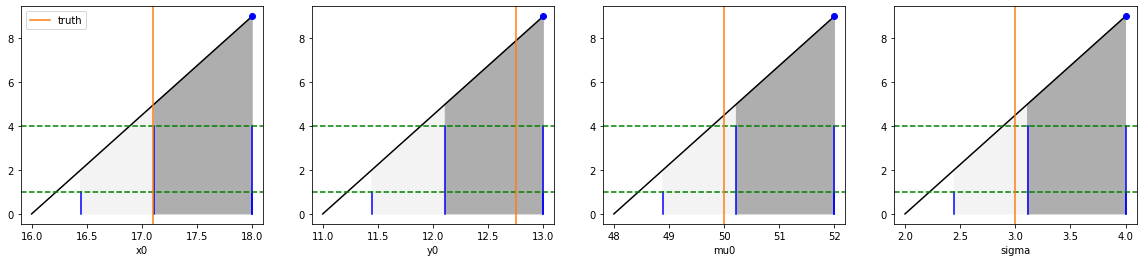

In [375]:
plt.rcParams['figure.figsize'] = (20.0, 4.0)
fig, ax = plt.subplots(1,4)
ci1d = [cr.whist_ci(marg, plot=axes) for marg,axes in zip(marg1d,ax)]
for i in range(4):
    ax[i].set_xlabel(paramnames[i])
    ax[i].axvline(truth[paramnames[i]], color='C1', label='truth');
ax[0].legend();

At this point, you are probably looking at some plots where only one point in the marginalized posterior is signficantly non-zero, and maybe some where the posterior doesn't go to zero by the edge. This is a good time to go back (maybe with a few iterations) and redefine the grid extent such that the posterior goes to zero a little inside either edge of these plots. Don't forget to also re-run the cell defining `*_values`, and re-run the grid evaluation and the cells in this section. And remember that the grid is still very course, to the CI's will never look acceptably well sampled (so we're not even bothering to print them out). We'll wait.

It won't look pretty, but hopefully (**checkpoint?**) your posteriors are consistent with the truth values (orange vertical lines above).

Once you've done that, before you get too comfortable, recall that the 1D credible intervals for say 95.4% probability will be narrower than any 2D or nD credible regions for the same probability, so if we go on to look at those then this grid might be too tight. We won't... hopefully the point is made that working on a grid (generally in more than 2D) is painful. We would need to spend significant time figuring out what part of parameter space we need to explore, and then waiting to evaluate over a grid with higher resolution than we used here. Instead, we'll just use more sensible methods in future notebooks, and you'll get to see what the results should look like.

## Curbing our ambition

Rather than give up on this tutorial entirely, let's simplify further to 2 free parameters, with the source position fixed to the truth. This might be the case if the source is already known and localized to much better than our current PSF by a higher-resolution observation in a different bandpass.

Using the power of arithmetic, I predict that we can evaluate a $100 \times 100$ grid over 2 parameters in the same time it took to do the $10 \times 10 \times 10 \times 10$ grid above. Here's an opportunity to change the grid extend, just in case you need to:

In [432]:
mu0_min = 49.8
mu0_max = 50.05
sigma_min = 2.75
sigma_max = 3.05

Let's define and run over this 2D grid:

In [433]:
%%time
dim = 100
mu0_values = np.linspace(mu0_min, mu0_max, dim)
sigma_values = np.linspace(sigma_min, sigma_max, dim)
lnpost_grid = np.empty((len(mu0_values), len(sigma_values)))
for k,mu0 in enumerate(mu0_values):
    for l,sigma in enumerate(sigma_values):
        lnpost_grid[k,l] = log_posterior(data, x0=truth['x0'], y0=truth['y0'], mu0=mu0, sigma=sigma)
post_grid = np.exp(lnpost_grid - lnpost_grid.max())

CPU times: user 9.06 s, sys: 11.3 ms, total: 9.07 s
Wall time: 9.08 s


Repeat your magic to find the 1D marginal posteriors

In [434]:
marg1d = [{'x':mu0_values, 'density': np.arange(100) },
         {'x':sigma_values, 'density': np.arange(100) }]

and let's have a look:

In [446]:
truth

{'x0': 17.1, 'y0': 12.75, 'mu0': 50.0, 'sigma': 3.0}

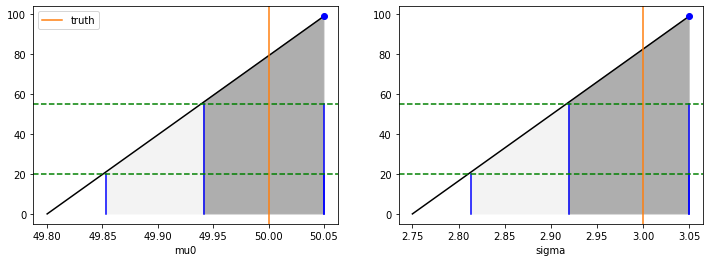

In [435]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig, ax = plt.subplots(1,2)
ci1d = [cr.whist_ci(marg, plot=axes) for marg,axes in zip(marg1d,ax)]
for i in range(2):
    ax[i].set_xlabel(paramnames[i+2])
    ax[i].axvline(truth[paramnames[i+2]], color='C1', label='truth')
ax[0].legend();

You can go back and refine the grid extent if this isn't beautiful enough for you, but it should look like a much better (plausibly smooth) sampling of the posterior.

We may as well also check out the 2D posterior. Here we'll find the credible regions corresponding to 1, 2, and $3\sigma$, since we want to make sure our grid contains nearly all of the posterior probability ($3\sigma$ corresponds to $\approx99.7$%).

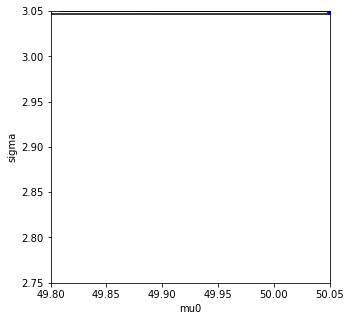

In [437]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
cr2d = cr.whist2d_ci({'x':mu0_values, 'y':sigma_values, 'z':post_grid.T}, sigmas=np.array([1,2,3]));
plt.xlabel('mu0');
plt.ylabel('sigma');

**Checkpoint:** is your grid wide enough to avoid cutting off the posterior distribution before it becomes tiny, while still resolving its shape?

If so, then great. Let's print out the 1D credible intervals, for posterity.

In [438]:
ci1d

[{'mode': 50.05,
  'level': array([0.68268949, 0.95449974]),
  'prob': array([0.68888889, 0.95757576]),
  'density': array([55, 20]),
  'min': array([49.94141414, 49.8530303 ]),
  'max': array([50.05, 50.05]),
  'low': array([-0.10858586, -0.1969697 ]),
  'high': array([0., 0.]),
  'center': array([49.99570707, 49.95151515]),
  'width': array([0.05429293, 0.09848485])},
 {'mode': 3.05,
  'level': array([0.68268949, 0.95449974]),
  'prob': array([0.68888889, 0.95757576]),
  'density': array([55, 20]),
  'min': array([2.91969697, 2.81363636]),
  'max': array([3.05, 3.05]),
  'low': array([-0.13030303, -0.23636364]),
  'high': array([0., 0.]),
  'center': array([2.98484848, 2.93181818]),
  'width': array([0.06515152, 0.11818182])}]

## Goodness of fit

We're not done yet! There's still the small matter of evaluating whether the model described the data well.

There are a few simple ways we might do this. Perhaps the most obvious is just to compare the image with the mean image, $\mu(x,y)$, for a representative set of parameters. For this purpose, let's use the posterior mode (the mean is also a common and reasonable choice).

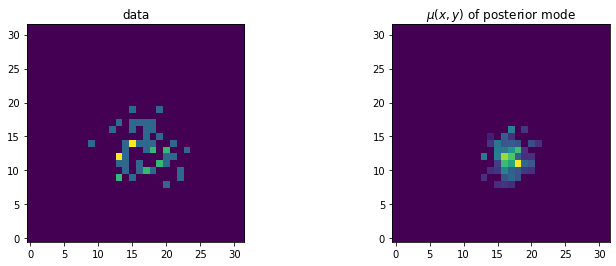

In [439]:
plt.rcParams['figure.figsize'] = (12.0, 4.0)
fig, ax = plt.subplots(1,2)
ax[0].imshow(data.im, origin='lower');
ax[0].set_title('data');
ax[1].imshow(mean_img(truth['x0'], truth['y0'], cr2d['mode'][0], cr2d['mode'][1]), origin='lower');
ax[1].set_title(r'$\mu(x,y)$ of posterior mode');

This definitely tells us _something_, but it's tough to judge whether the width parameter $\sigma$ matches by eye given the Poisson noise in the data, not to mention it tells us nothing about $\mu_0$ directly.

Beyond this, we could compare the number of photons in the data to posterior predictions from the model, and, separately their spatial distribution. For this, it will be helpful to generate samples $(\mu_0,\sigma)$ from our gridded posterior distribution, which the cell below accomplishes.

In [440]:
mu0_values2,sigma_values2 = np.meshgrid(mu0_values, sigma_values, indexing='ij')
j = np.random.choice(np.prod(post_grid.shape), size=10000, p=post_grid.flatten()/post_grid.sum())
mu0_ppd = mu0_values2.flatten()[j]
sigma_ppd = sigma_values2.flatten()[j]

Use the arrays `mu0_ppd` and `sigma_ppd` to produce an array `N_ppd` of posterior predictions for the total number of photons in the image. Note that both `mu0_ppd` and `sigma_ppd` are needed in order to account for the small probability of a photon landing outside of the image and not being counted. Hint: your `mean_img` function can be useful here, even if it isn't the most efficient way of accomplishing things.

In [441]:
N_ppd = []
for i in range(len(mu0_ppd)):
    dat=mean_img(truth['x0'], truth['y0'], mu0_ppd[i], sigma_ppd[i])
    N_ppd.append(sum(sum(dat)))

Let's compare that to the data:

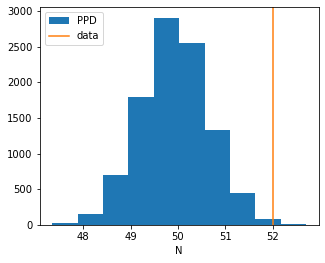

In [442]:
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.hist(N_ppd, label='PPD');
plt.axvline(data.im.sum(), color='C1', label='data');
plt.legend();
plt.xlabel('N');

Next, generate posterior predictions for $x-x_0$ or $y-y_0$ offsets of photons from the source position (the two are equivalent, since we assumed the PSF was symmetric). Note that this is actually extremely simple by comparison (1 line), and does not require the code below that finds offsets in the data.

In [443]:
dxy_ppd = []
dat=mean_img(truth['x0'], truth['y0'], truth['mu0'], truth['sigma'])
for i in range(32):
    for j in range(32):
        if dat[i][j]!=0:
            dxy_ppd.append(i-truth['x0']+1)
            dxy_ppd.append(i-truth['y0']+1)

The code below laboriously finds the $x$ and $y$ photon offsets in the data, and returns them as a list of offsets and weights, the latter corresponding to the number of photons with that offset.

In [444]:
def find_offsets(image, x0, y0):
    j = np.where(image.im.flatten() > 0)[0]
    return (np.concatenate((image.imx.flatten()[j] - x0, image.imy.flatten()[j] - y0)), 
            np.concatenate((image.im.flatten()[j], image.im.flatten()[j])))

dxy_data = find_offsets(data, truth['x0'], truth['y0'])

Let's compare that distribution with your prediction:

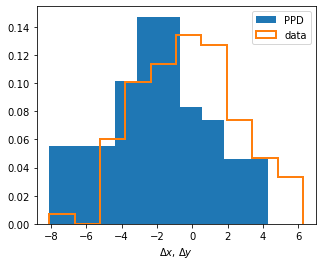

In [445]:
plt.hist(dxy_ppd, density=True, label='PPD');
plt.hist(dxy_data[0], weights=dxy_data[1], density=True, histtype='step', lw=2, label='data');
plt.xlabel(r'$\Delta x$, $\Delta y$');
plt.legend();

**Checkpoint:** Once again, the random nature of the mock data means we can't say exactly what this will look like for you, but the data and PPDs should appear compatible.

Finally, it's perhaps worth knowing that, for the Poisson likelihood, the expectation value and variance of $C=-2\ln\mathcal{L}$ (with $\mathcal{L}$ the likelihood), has been approximated to useful precision. These formulae are accurate in the limit of many data points, which in our case means many pixels (not photons necessarily). This means we can, if we want, do a goodness of fit test analogous to the frequentist $\chi^2$ test. There is nothing TBC below, but we go through the motions as an illustration.

In [414]:
from cashstatistic import cash_mod, cash_mod_expectations

The first of the functions above computes $C$ from the data, and its expectation value and variance from a model, $\mu(x,y)$. In each case, the calculations are pixel-wise, and the total $C$ (or expectation, or variance) is found by summing the result over the image. In the large-data limit, $C$ should be consistent with a normal distribution with the given expectation and variance.

Here we find the $C$ corresponding to the posterior mode (logically, we should probably have used the maximum likelihood if we are in frequentist mode, but it makes little difference here):

## Parting thoughts

So, we've gamely applied our inference tools to an oversimplified toy problem and... run into a computational bottleneck that seems to make them useless in practice. Unsatisfying? Perhaps. But fear not! The next part of the course will cover computational methods that will make this problem quite straightforward.